
# Projection Methods


The purpose of this notebook is to understand and implement different projection methods. In particular we will look at:



1.   Principle component analysis (PCA)
2.   Singular value decomposition (SVD)
3.   Non-Negative Matrix Factorization (NMF)


These methods are forms of matrix decompositions, whereby the matrix can be factorised into the product of matrices. Matrix factorisation can reduce a matrix into constituent parts that make it easier to calculate more complex matrix operations. These methods form the foundation of linear algebra in computers, even for basic operations such as solving systems of linear equations, calculating the inverse, and calculating the determinant of a matrix. However, we will predominantly use these methods for dimensionality reduction, i.e. reducing the number of features for purposes of supervised, unsupervised learning and visualisation.

All of these methods can be implemented using python libraries such as sklearn, however, here we will choose to implement these methods manually.



In [49]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc

from sklearn.datasets import fetch_openml

Lets first load some data. We will use the mnist dataset again for this problem.

In [50]:
# loading images
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

/Users/carlosperello/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [51]:
images = images.to_numpy()

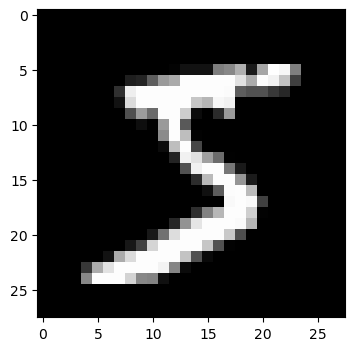

In [52]:
# plot the first image
plt.figure(figsize=(4,4))
plt.imshow(images[0].reshape(28,28), cmap='gray');

Lets now preprocess the data together. When you are working on real world problems, you will need to do all these steps by yourself.

The steps below ensure that our images will have zero mean and one variance. These preprocessing
steps are also known as [Data Normalization or Feature Scaling](https://en.wikipedia.org/wiki/Feature_scaling).


The preprocessing steps we will do are:
1. Convert unsigned interger 8 (uint8) encoding of pixels to a floating point number between 0 and 1.






In [117]:
# Some preprocessing of the data

# we take the first 1000 images
n_datapoints = 1000

# reshaping and taking a slice of the data
X = (images.reshape(-1, 28 * 28)[:n_datapoints]) / 255.

The next two steps of the preprocessing is:

2. Subtract from each image the mean $\boldsymbol \mu$.
3. Scale each dimension of each image by $\frac{1}{\sigma}$ where $\sigma$ is the stardard deviation.

In [118]:
def normalize(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

In [119]:
X = normalize(X)

# 1. PCA

Now we will implement PCA. Before we do that, let's pause for a moment and
think about the steps for performing PCA. Assume that we are performing PCA on
some dataset $\boldsymbol X$ for $k$ principal components. 
We then need to perform the following steps, which we break into parts:

1. Compute the covariance matrix  $\mathbf C = \mathbf X^\top \mathbf X/(n-1)$
1. Find eigenvalues and corresponding eigenvectors for the covariance matrix, $\mathbf C = \mathbf V \mathbf L \mathbf V^\top,$
3.  Sort by the largest eigenvalues and the corresponding eigenvectors.
4.  Compute the projection onto the spaced spanned by the top $n$ eigenvectors.





In [120]:
X.shape

(1000, 784)

In [121]:
## EDIT THIS FUNCTION

from scipy.sparse import linalg

def pca_function(X,k):
    n = X.shape[0]
    # create covariance matrix S
    C = (X.T@X)/(n-1) ## <-- EDIT THIS LINE


    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, k, which="LM", return_eigenvectors=True) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:,sorted_index ]

    # transform our data
    top_eigenvectors = eigenvectors[:,:k]
    X_pca = X@top_eigenvectors

    return X_pca, eigenvectors, eigenvalues

Lets now apply our PCA function to create three principle components, k=3.

In [122]:
# choose our number of principle components
k = 3

# compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = pca_function(X,k) 


Lets now plot our original images projected onto a 2d plane

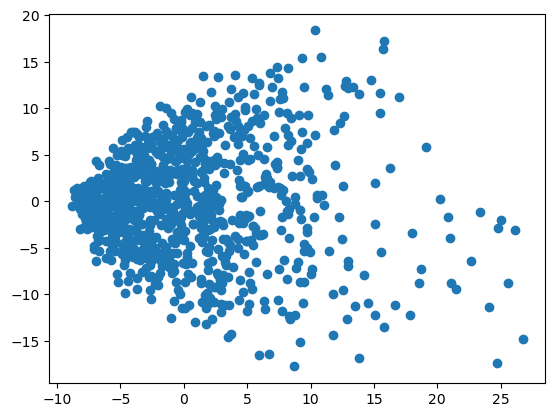

In [123]:
plt.scatter(X_pca[:,0],X_pca[:,1])
plt.show()

Lets now compute the variance in each principle component. Then print the variance for the first three principle components.

In [124]:
## EDIT HERE

explained_variances = eigenvalues[:k]/np.sum(eigenvalues) ## <-- EDIT THIS LINE
print('The explained variance for the first three principle components is: {}'.format(explained_variances))

The explained variance for the first three principle components is: [0.39257941 0.33139676 0.27602383]


Lets now repeat this using the sklearn PCA function to confirm we have done it correctly.

The visual might be inversed but the relative distances between points is consistent.

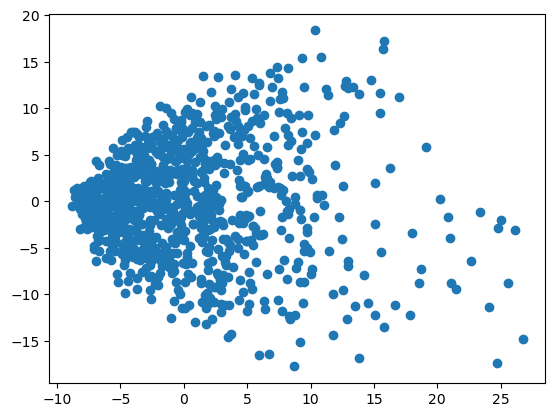

In [125]:
from sklearn.decomposition import PCA
pca = PCA(n_components=k, svd_solver='full')
X_sk_pca = pca.fit_transform(X)
plt.scatter(X_sk_pca[:,0],X_sk_pca[:,1])
plt.show()


In [126]:
pca.explained_variance_ratio_

array([0.06494624, 0.05482451, 0.04566391])

Lets now try and understand what these different principle components represent for a given image!

Lets plot the first 25 eigenvectors reshaped into their original image size.


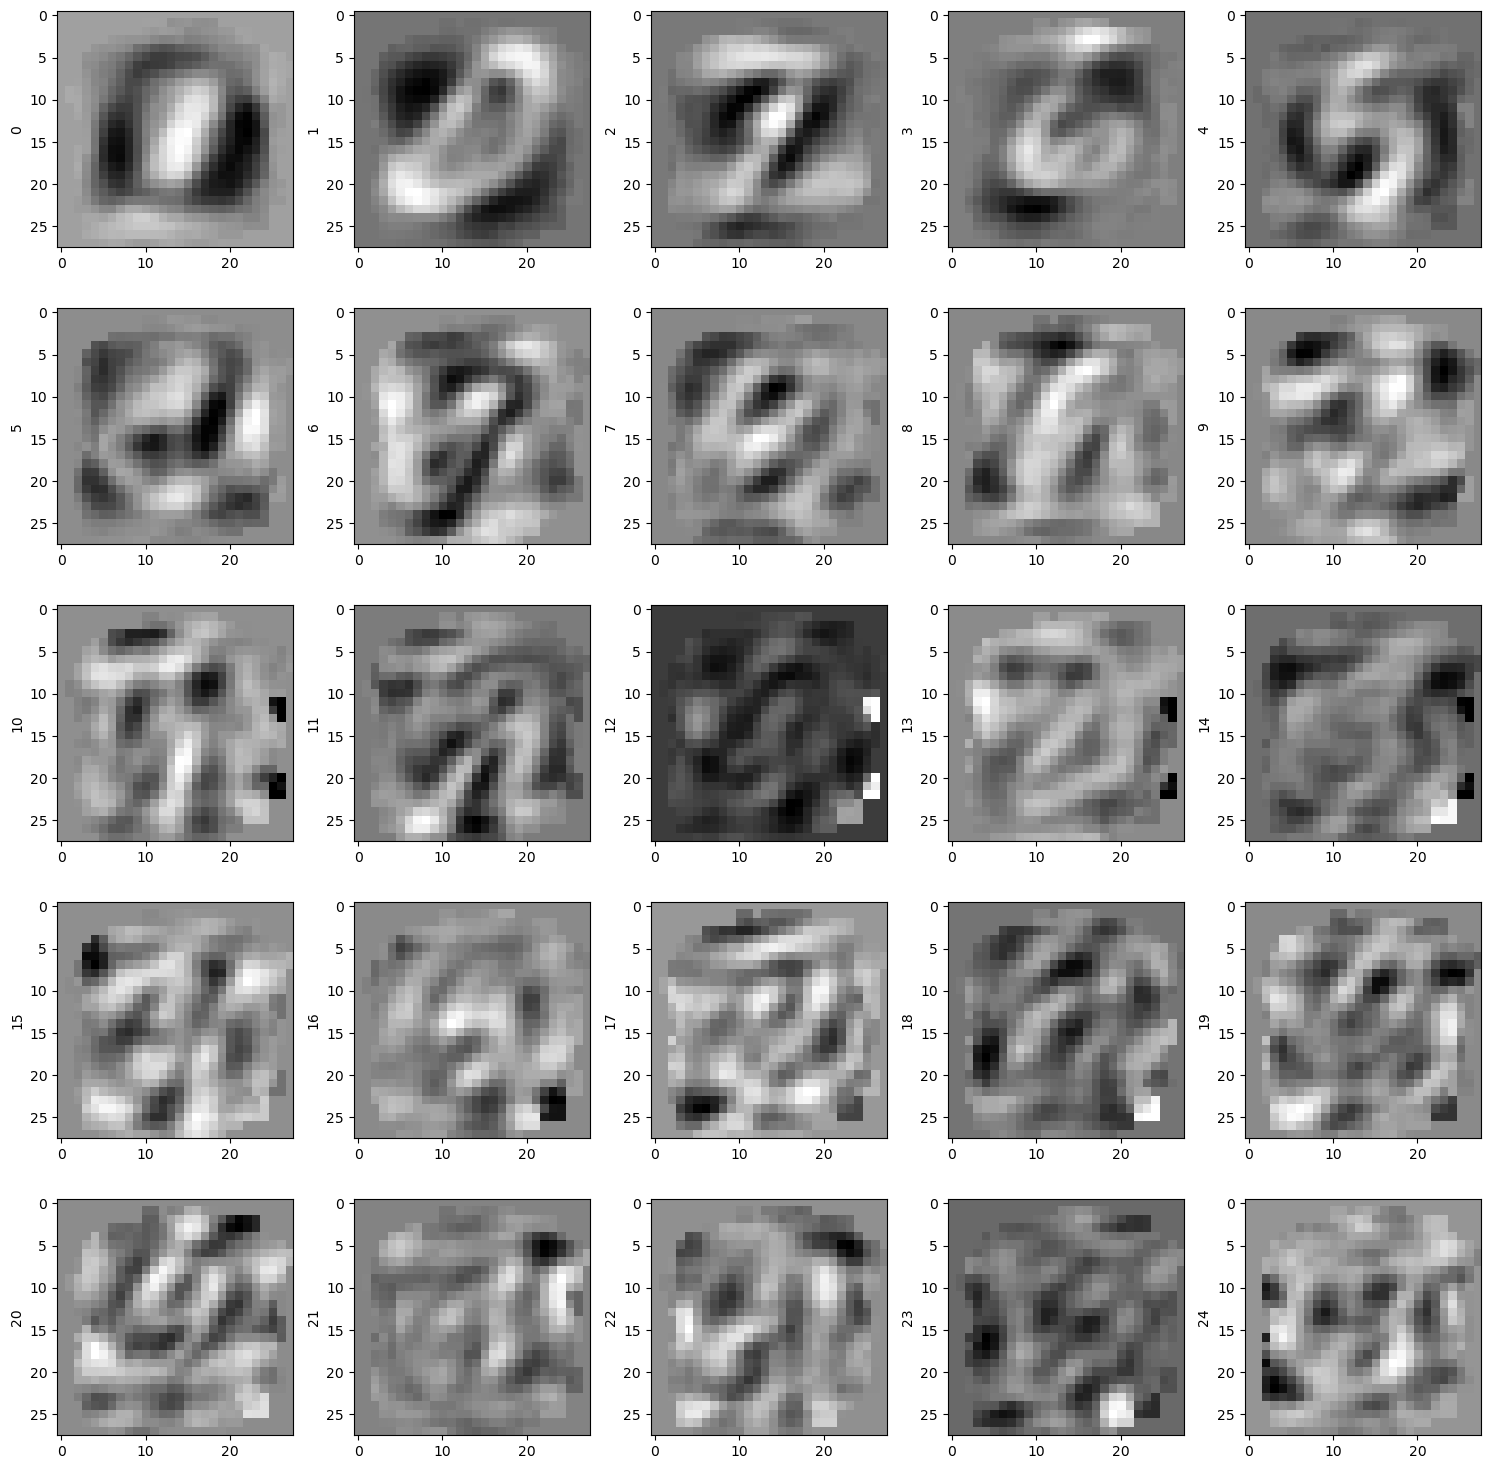

In [127]:
## EDIT HERE

k = 25
X_pca, eigenvectors, eigenvalues = pca_function(X,k)

nrow = 5; ncol = 5;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(15,15))

for i, ax in enumerate(axs.reshape(-1)): 
    ax.imshow(eigenvectors[:,i].reshape([28,28]),cmap='gray')
    ax.set_ylabel(str(i))

fig.tight_layout()
plt.show()



# 2. SVD

We now want to perform a singular value decomposition of our data,


$$
\mathbf X = \mathbf U \mathbf S \mathbf V^\top,
$$



where $\mathbf U$ is the unitary matrix, $\mathbf S$ is the diagonal matrix of singular values $s_i$, and  $\mathbf V$ are the principal directions/axes.

We can see a link with PCA at this moment; we can compute the covariance matrix as,


$$
\mathbf C = \mathbf V \mathbf S \mathbf U^\top \mathbf U \mathbf S \mathbf V^\top /(n-1) = \mathbf V \frac{\mathbf S^2}{n-1}\mathbf V^\top,
$$


which confirms that $\mathbf V$ are the principal directions/axes, and the columns of $\mathbf U \mathbf S$ are our principal components. The singular values $\lambda_i = s_i^2/(n-1)$ correspond to the eigenvalues.


We can define our principal components explicitly as,


$$\mathbf X \mathbf V = \mathbf U \mathbf S \mathbf V^\top \mathbf V = \mathbf U \mathbf S$$


To perform the SVD we will just use the [svd](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html) function from scipy.



In [128]:
## EDIT HERE

# lets use the SVD algorithm from sklearn
U, s, V = sc.linalg.svd(X, full_matrices=True) ## <-- EDIT THIS LINE

Now compute the project of the features X by dot product with the principle axes V.

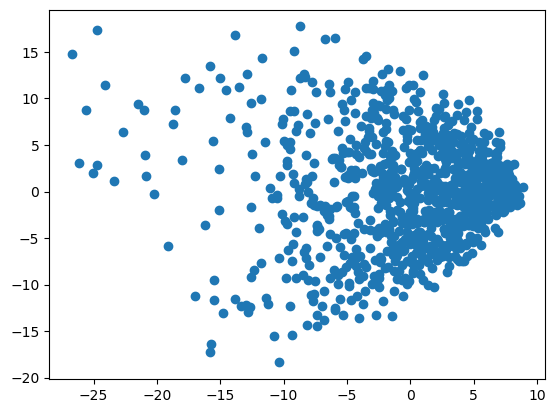

In [129]:
## EDIT HERE

# given our decomposition, create the projection of our features X by dot product with the principle axes V

X_svd = X @ V.T
plt.scatter(X_svd[:,0],X_svd[:,1])
plt.show()

To confirm that we have performed the projection correctly, lets use the [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD) function from sklearn.

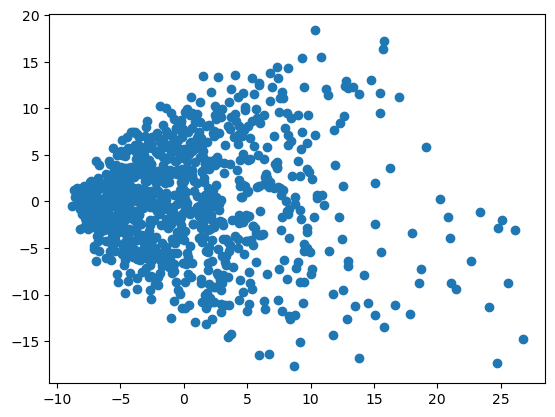

In [130]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X)
plt.scatter(X_svd[:,0],X_svd[:,1])
plt.show()


# 3. NMF

Now we will look at non-negative matrix factorisation. NMF is a matrix factorization method where we constrain the matrices to be nonnegative. PCA previously produced factors that could be both positive and negative. 

NMF factors our n-by-m feature matrix $\mathbf X$ into nonnegative factors $\mathbf W$ (n-by-k) and $\mathbf H$ (k-by-m). The factorization is not exact. $\mathbf W\mathbf H$ is a lower-rank approximation to $\mathbf A$. The factors $\mathbf W$ and $\mathbf H$ minimize the root mean square residual D between $\mathbf X$and $\mathbf W\mathbf H$.

Note that for non-negative matrix factorisation we require the input matrix to be non-negative. Therefore, we must normalise between 0 and 1 instead of standard normalise which we used for PCA and SVD.


Here we will use Lee and Seung's multiplicative update rule. 


$$
\mathbf{H}_{[i,j]}^{n+1}\leftarrow \mathbf{H}_{[i,j]}^{n} 
\frac{(( \mathbf{W}^n)^T \mathbf{X})_{[i,j]}}{((\mathbf{W}^n)^T \mathbf{W}^n \mathbf{H}^n)_{[i,j]}}
$$


and


$$
\mathbf{W}_{[i,j]}^{n+1}\leftarrow \mathbf{W}_{[i,j]}^{n} 
\frac{(\mathbf{X}(\mathbf{H}^{n+1})^T)_{[i,j]}}{(\mathbf{W}^n \mathbf{H}^{n+1} (\mathbf{H}^{n+1})^T)_{[i,j]}}
$$

until $\mathbf{W}$ and $\mathbf{H}$ are stable. It is important to note that updates are done on an element by element basis and not matrix multiplication.



In [131]:
## EDIT THIS FUNCTION

# normalise min max to 0-1
def normalize_nmf(X):
    X_norm = (X - np.min(X)) / (np.max(X) - np.min(X))
    return X_norm

X = normalize_nmf(X)

Since we are performing an optimisation, we will need to have some placeholder matrices with random numbers.

In [132]:
# choosing the number of dimensions on which to project
k = 2

# setting the random seed (just so everyone gets the same results...)
np.random.seed(0)

# m x k components matrix, usually interpreted as the coefficients, where m is the number of data
W = np.random.rand(X.shape[0], k)

# k x n matrix interpreted as the basis set, where n is the number of features (e.g. pixels)
H = np.random.rand(k, X.shape[1])

An optimisation needs a cost function, which we define as the root mean square residuals between our original feature matrix X and our the product of our two factored matrices.

Our chi2 can be defined as,


$$
\chi^2 = \frac{e^⊤ (X \odot d \odot d) e}{ n}
$$

where d is the difference $d = X - WH$, and e is a vector of all ones where $e^⊤ K e$ simply performs a sum over all elements in K, and $n$ is the total number of elements in $X$.

The symbol $\odot$ is the element wise product (Hadamard product).


In [133]:
## EDIT HERE

# lets define a cost matrix to compare the difference
def cost(X,W,H):
    n = X.shape[0] + X.shape[1]
    # compute the difference between X and the dot product of W and H
    diff = X-W@H ## <-- EDIT THIS LINE
    chi2 = (np.sum((X * diff * diff)))/n ## <-- EDIT THIS LINE

    return chi2

Now implement Lee and Seung's multiplicative update rule. First implement the update on H and then the update on W. Finally compute the chi2.

In [134]:
## EDIT HERE

# set the number of iterations
n_iters = 200

# empty list for chi2 
chi2 = []

# loop over the n iterations
for i in range(n_iters):

  # compute the update on H
  H = H * ((W.T @ X) / (W.T @ W @ H))

  # compute the update on W
  W = W * ((X @ H.T) / (W @ H @ H.T))

  # compute the chi2 and append to list
  chi2.append(cost(X,W,H))


$$
\mathbf{H}_{[i,j]}^{n+1}\leftarrow \mathbf{H}_{[i,j]}^{n} 
\frac{(( \mathbf{W}^n)^T \mathbf{X})_{[i,j]}}{((\mathbf{W}^n)^T \mathbf{W}^n \mathbf{H}^n)_{[i,j]}}
$$


and


$$
\mathbf{W}_{[i,j]}^{n+1}\leftarrow \mathbf{W}_{[i,j]}^{n} 
\frac{(\mathbf{X}(\mathbf{H}^{n+1})^T)_{[i,j]}}{(\mathbf{W}^n \mathbf{H}^{n+1} (\mathbf{H}^{n+1})^T)_{[i,j]}}
$$

We should next check to confirm that we have converged to a solution by plotting the chi2 of our cost function over the iterations.

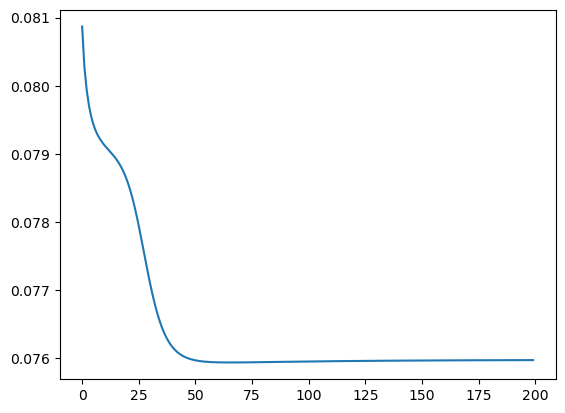

In [135]:
# plotting the cost
plt.plot(chi2)
plt.show()

We can see above that we have converged in optimising our NMF according to the chi2 cost function.

Lets now plot our components using the matrix W.


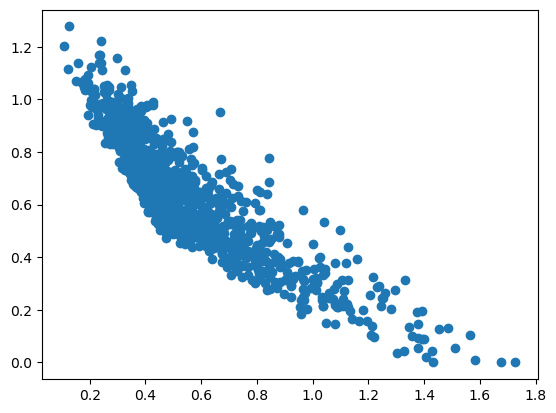

In [136]:
plt.scatter(W[:,0],W[:,1])
plt.show()


We can now do this using sklearn and check that our methodology was implemented correctly.

/Users/carlosperello/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


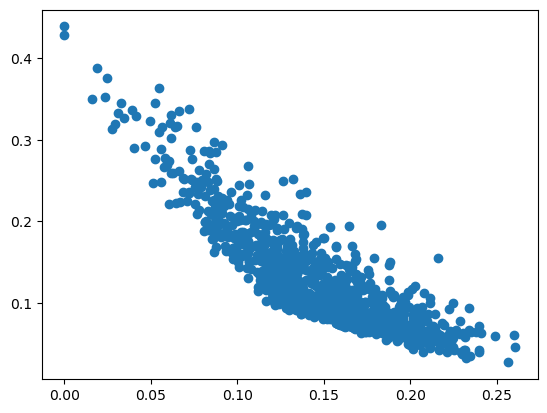

In [137]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=k, init='random', random_state=0)
W = nmf.fit_transform(X)
plt.scatter(W[:,0],W[:,1])
plt.show()

Finally, we can have a look at the difference components resulting from our NMF and see what information they might contain.

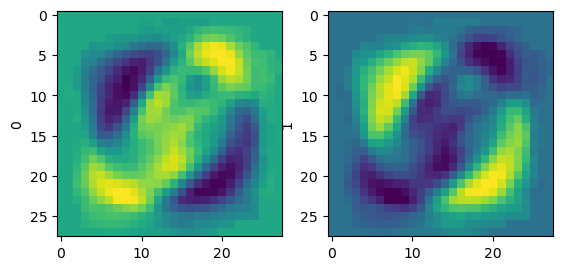

In [138]:

nrow = 1; ncol = 2;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol)

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(nmf.components_[i,:].reshape([28,28]))
    ax.set_ylabel(str(i))